# Atmosphere Plotter Notebook. Version 3. AggregateRandomPhases

----
### Aggregate Random Phases

#### This notebook take instances of production1_randomPhase1-5 to generate averaged-variability + color-inclination trends.
----

### readme: problem statement, step listing, scenarios names

This notebook read the spectral datacubes generated by `PolarVortice/AtmosphereGenerator.py`.

The datacubes are located at `PolarVortice/output/`. In this script, I configured it to read only `production` datacubes.

1. **Step 1**: Read Spectral Monitoring Data 
2. **Step 2**: Generate Synthetic Spectra Cube with Sonora
3. **Step 3**: Reproduce Color-inclination plots
4. **Step 4**: Replot for the scenario No Vortex/nothing.
5. **Step 5**: Reproduce variability-inclination plots

----
Scenario names crossmatch with Fuda et al. 2024b: The scenario name in this code is different from the journal paper.
- `'nothing'`:     is the same as `'No Vortex'`
- `'polarStatic'`: is the same as `'Evolving Vortex'`
- `'noPolar'`:     is the same as `'Static Vortex'`
----

#### Step 0: Initialization

In [1]:
import astropy.constants as c
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
import re
import h5py
from astropy.convolution import convolve, Box1DKernel
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
import scipy as sp
import scipy.interpolate

matplotlib.rcParams.update({'font.size': 12})

colorList = {'polarStatic':'tab:blue', 'polarDynamic':'k', 'noPolar':'tab:red', 'nothing':'tab:purple'}
colorAlias = {'JH_color':'Time-averaged [J-H] color', 'JK_color':r'Time-averaged [J-K$_s$] color', 'silicateIndex':'Si-index'}
markers = ['s', '^', '+']
aliasList = {'polarStatic':'Evolving Vortex', 'polarDynamic':'k', 'noPolar':'Stationary Vortex', 'nothing':'No Vortex'}

### Rerun to calculate fluxes and amplitudes ###
# rerun = True
rerun = False

In [2]:
### ========= function to print levels of nested dicts =================
def print_nested_dict(d, indent=0):
    for key, value in d.items():
        print("  " * indent + str(key) + ":")
        if isinstance(value, dict):
            print_nested_dict(value, indent + 1)
        else:
            print("  " * (indent + 1) + str(value))

### ========= lamda function to create nested_dict ======================
def nested_dict():
    return defaultdict(nested_dict)

### ========= function to bring array value to one ======================
def bring_to_one(array):
    shift = (array.max() + array.min())/2
    return 1 + array - shift

### ========= itertools to generated random marker =====================
import itertools
markerRandomList = itertools.cycle((',', '+', '.', 'o', '*'))
linestyleRandomList = itertools.cycle(('--', '-', '-.', ':', ''))
### Usage
# for n in y:
#     plt.plot(x,n, marker = next(marker), linestyle='')

### =========  Function to do log-log interpolation =====================
def log_interp1d(xx, yy, kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

### =========  Path to save plot figures ================================
plotPath = '/Users/nguyendat/Documents/GitHub/polar_vortice/PolarVortice/AtmopsherePlotterOutputPlots/'

## Step 1: Read Spectral Monitoring Data Cube

#### Initialization

- Choose class of models to read.
- model_class, model_id, inclination, starting_time, end_time, frame_numbers
- data structure:

dict:static|dynamic|nopolar|
=> dict:inclination_value:'string' 
=> dict:time_value:'string' 
=> numpy:gray_array:2d_image

- aggregate all instances of production1 with different phase offsets

#### 1A) [read, print] Read files into 1 dictionary contain 2 classes: Polar_static, NoPolar

In [3]:
directory = "/Users/nguyendat/Documents/GitHub/polar_vortice/PolarVortice/output/"
production_list = []
foldernameLists = []
other_list = []

productionKey = 'production1_phaseRandomized'

print('============================================================')
print('Production key: "%s"'%productionKey)
print('\nThe production datacubes includes:')
for foldername in os.listdir(directory):
    if productionKey in foldername and 'polarDynamic' not in foldername:
        print(foldername)
        foldernameLists.append(foldername)
        production_list.append(directory+foldername+'/')
    else:
        other_list.append(directory+foldername+'/')
print('============================================================')
print('\n')

production_keys = []
for s in foldernameLists:
    match = re.search(r'\[([^\]]+)\]', s)
    production_keys.append(match.group(1))
        
production_keys = sorted(list(set(production_keys)))

# ================================================================
# Function to categorize file names
# ================================================================
def categorize_filenames(directory_list):
    # create empty, pre-nested dicts
    datacubes = nested_dict()
    metadatas = nested_dict()
    
    for directory in directory_list:
        # Iterate over files in the directory
        for filename in os.listdir(directory):
            # print(filename)
            # Check if the file is a H5 file
            if filename.endswith(".h5"):
                parts = re.findall("\[(.*?)\]", filename)
                model_id = str(parts[1])
                class_name = str(parts[0])
                incli_value = str(parts[2])
                t1t2FrameNo_value = parts[3] + "-" + parts[4] + "-" + parts[5]

                # Load numpy array from H5 file
                with h5py.File(os.path.join(directory, filename), 'r') as f:
                    data = f['dataset'][:]
                    datacubes[model_id][class_name][incli_value][t1t2FrameNo_value] = data
            
            # Check if the file is a pickle file
            if filename.endswith(".pkl"):
                parts = re.findall("\[(.*?)\]", filename)
                model_id = parts[2]
                class_name = parts[1]
                incli_value = parts[3]
                t1t2FrameNo_value = parts[4] + "-" + parts[5] + "-" + parts[6]

                # Load metadata from pickle file
                with open(os.path.join(directory, filename), 'rb') as f:
                    data = pickle.load(f)
                    metadatas[model_id][class_name][incli_value][t1t2FrameNo_value] = data
                    
    return datacubes, metadatas

# read the production datacube
datacubes, metadatas = categorize_filenames(production_list)
print('Done reading the production datacubes')

Production key: "production1_phaseRandomized"

The production datacubes includes:
dataCube[production1_phaseRandomized10][polarStatic][i][0][60][60]
dataCube[production1_phaseRandomized1][noPolar][i][0][60][60]
dataCube[production1_phaseRandomized5][noPolar][i][0][60][60]
dataCube[production1_phaseRandomized5][polarStatic][i][0][60][60]
dataCube[production1_phaseRandomized6][noPolar][i][0][60][60]
dataCube[production1_phaseRandomized9][noPolar][i][0][60][60]
dataCube[production1_phaseRandomized4][polarStatic][i][0][60][60]
dataCube[production1_phaseRandomized1][polarStatic][i][0][60][60]
dataCube[production1_phaseRandomized2][noPolar][i][0][60][60]
dataCube[production1_phaseRandomized2][polarStatic][i][0][60][60]
dataCube[production1_phaseRandomized7][polarStatic][i][0][60][60]
dataCube[production1_phaseRandomized4][noPolar][i][0][60][60]
dataCube[production1_phaseRandomized8][polarStatic][i][0][60][60]
dataCube[production1_phaseRandomized3][noPolar][i][0][60][60]
dataCube[production1_

In [4]:
# ============================================================
# Print bookkeeping information
# ============================================================
display_bookkeep = False
# display_bookkeep = True

for productionKey in production_keys:

    modelclasses = []
    modelclasses = list(datacubes[productionKey].keys())
    if display_bookkeep:
        print('============================================================')
        print('--> production name:', productionKey)

    for model in modelclasses:
        incli = list(datacubes[productionKey][model].keys())
        incli = sorted([int(x) for x in incli]) 
        incli = [str(x) for x in incli]

        photo_config = list(datacubes[productionKey][model][incli[0]].keys())
        
        # =======================================================
        # Choose which photometry configuration to use: 
        # Currently photo_config
        # =======================================================

        for config in photo_config:
            if config == '0-60-60':
                
                photo_config0 = config
                # print('\n--> Using the photometry config: [%s] (t0-t1-no_frame)'%photo_config0)
                if display_bookkeep:
                    print('----> [%s] contains these inclination'%model, sorted(incli))

                    randphasevalue = metadatas[productionKey][model]['0'][photo_config0]['randPhase']
                    print('---------> Random phases at each inclination:')
                    for line in randphasevalue:
                          print('---------> ', line[0], ':', line[1])
                      
                metakeys = list(metadatas[productionKey][model][incli[0]][photo_config0].keys())
                no_frame = datacubes[productionKey][model][incli[0]][photo_config0].shape[0]
                t0, t1 = int(photo_config0.split('-')[0]), int(photo_config0.split('-')[1])

                time_array = np.linspace(t0, t1-1, no_frame) 

    # print('\n--> The metadata contains these attributes: \n', metakeys)
    # print('============================================================')

In [5]:
incli

['-90', '-80', '-70', '-60', '-50', '-40', '-30', '-20', '-10', '0']

#### 1B) [plot] Photometry and specmaps 

In [6]:
# ============================================================
# [[Plot]]
# Plot the first photometry-frame, spectra-map for one inclin
# of each model class
# ============================================================

photo_config0 = '0-60-60'
# photo_config0 = '0-30-30'
no_frame = datacubes[productionKey][model][incli[0]][photo_config0].shape[0]

%matplotlib inline
plt.close('all')
for iang in ['-20', '-60']:
    # fig, axs = plt.subplots(1, 3, dpi=120, figsize=(9,3))
    cadence = (t1-t0)/no_frame
    # fig.suptitle('Photometry and Specmap at Inclination i=%s deg.'%iang)
    for i, model in enumerate(modelclasses):
        photo_config0 = photo_config[0]
        if model == 'polarStatic': timepoint = 0
        else: timepoint = 0
        gray = datacubes[productionKey][model][iang][photo_config0][timepoint][0]
        # axs[i].imshow(gray)
        # axs[i].set_title(model)
        # axs[i].set_xticks([]), axs[i].set_yticks([])
        # axs[i].set_xticks([]), axs[i].set_yticks([])

    specmap = metadatas[productionKey][model][iang][photo_config0]['specmap']
#     axs[2].imshow(specmap, cmap='inferno')    
#     axs[2].set_xticks([]), axs[2].set_yticks([])

#     axs[0].set_xlabel('Photometry at t=%.1f hr'%(timepoint*cadence))
#     axs[1].set_xlabel('Photometry at t=%.1f hr'%(timepoint*cadence))
#     axs[2].set_xlabel('Spectral Lookup Map, i=%s deg.'%iang)

#### 1C) [read, create, calculate, plot] Creating flux dictionaries

This section will assume one is using one identical time-array for 3 model classes.

In [7]:
production_keys = production_keys[:6]
production_keys

['production1_phaseRandomized1',
 'production1_phaseRandomized10',
 'production1_phaseRandomized2',
 'production1_phaseRandomized3',
 'production1_phaseRandomized4',
 'production1_phaseRandomized5']

In [8]:
# ============================================================
# Read photometry cubes, mask out region by feature-class 
# and save the *fluxes*, as well as *masked images*
# and the masked specmaps *specmasks*
# ============================================================

photo_config0 = '0-60-60'
# photo_config0 = '0-30-30'
no_frame = datacubes[productionKey][model][incli[0]][photo_config0].shape[0]

## ============================================================
if rerun:
    
    fluxes = nested_dict() # format: normflux, flux_bytype, fraction_bytype
    images = nested_dict() # format: [frameim, ambim, bandim, polim]
    specmasks = nested_dict() # format: [is_amb, is_band, is_pol]

    do_gaussian_filter = False

    gaussian_sigma = 0

    for counter, productionKey in enumerate(production_keys[:7]):
        for model in modelclasses:
            for iang in incli:
                meta_iang = metadatas[productionKey][model][iang][photo_config0]
                specmap = meta_iang['specmap']
                con_amb = meta_iang['cond_is_amb']
                is_amb = ((specmap >= con_amb[0]) & (specmap < con_amb[1])).astype(int)
                con_band = meta_iang['cond_is_band']
                is_band = ((specmap >= con_band[0]) & (specmap < con_band[1])).astype(int) 
                con_pol = meta_iang['cond_is_pol']
                is_pol = ((specmap >= con_pol[0]) & (specmap < con_pol[1])).astype(int)

                flux = []
                fluxtyp = []

                # Prepare a dictionary of specmap masks
                specmap_total = metadatas[productionKey][model][iang][photo_config0]['specmap']
                specmap_amb = specmap*is_amb
                specmap_band = specmap*is_band
                specmap_pol = specmap*is_pol

                specmap_total[specmap_total == 0] = np.nan
                specmap_amb[specmap_amb == 0] = np.nan
                specmap_band[specmap_band == 0] = np.nan
                specmap_pol[specmap_pol == 0] = np.nan

                frac_amb = np.nansum(specmap_amb)/np.nansum(specmap_total)
                frac_band = np.nansum(specmap_band)/np.nansum(specmap_total)
                frac_pol = np.nansum(specmap_pol)/np.nansum(specmap_total)

                specmasks[model][iang][counter] = [specmap_total, specmap_amb, specmap_band, specmap_pol]

                for t in range(no_frame):
                    gray = datacubes[productionKey][model][iang][photo_config0][t][0]
                    if do_gaussian_filter:
                        frameim=gaussian_filter(gray, sigma=gaussian_sigma)
                    else: frameim = np.copy(gray)

                    ## mask-out band and pole and calculate their 
                    ## respective flux contribution at each frame
                    ambim, polim, bandim = frameim * is_amb, frameim * is_pol, frameim * is_band

                    ambim[ambim == 0] = np.nan
                    bandim[bandim == 0] = np.nan
                    polim[polim == 0] = np.nan
                    frameim[frameim == 0] = np.nan

                    scalingConst = 1/30000
                    fluxtyp.append([np.nansum(ambim)*scalingConst, np.nansum(bandim)*scalingConst, np.nansum(polim)*scalingConst])
                    flux.append(np.nansum(frameim)*scalingConst)

                    # prepare dictionary of photometries
                    images[model][iang][counter][t] = [frameim, ambim, bandim, polim]

                # prepare dictionary of fluxes
                flux = np.array(flux)
                fluxtyp = np.array(fluxtyp)

                fluxes[model][iang][counter]['norm'] = flux

                fluxes[model][iang][counter]['bytype']['amb'] = np.transpose(fluxtyp)[0] # 1: amb, 2: band, 3: pol
                fluxes[model][iang][counter]['bytype']['band'] = np.transpose(fluxtyp)[1]
                fluxes[model][iang][counter]['bytype']['pol'] = np.transpose(fluxtyp)[2]

                fluxes[model][iang][counter]['fraction']['amb'] = frac_amb 
                fluxes[model][iang][counter]['fraction']['band'] = frac_band
                fluxes[model][iang][counter]['fraction']['pol'] = frac_pol 

In [9]:
if rerun:
    # ============================================================
    # [[Plot]]
    # Plot all norm_flux with time for each inclinations
    # in each model classes
    # ============================================================    
    plt.close()
    # markList4 = {'0':'*', '-30':'.', '-60':'x', '-90':'^'}
    for model in modelclasses: 
        fig, axs = plt.subplots(1,2, dpi=120, figsize=(16,3))
        for i, iang in enumerate(['0', '-90']):
            for counter, productionKey in enumerate(production_keys):
                y_flux = fluxes[model][iang][counter]['norm']

                line, = axs[i].plot(time_array, y_flux, c=colorList[model],
                                    ls=next(linestyleRandomList), marker=next(markerRandomList),
                                 alpha=0.5, label=r'randPhase%i'%counter)

                axs[i].set_xlim(-1, 80), axs[i].set_ylim(1.5, 2.6)
                axs[i].set_xlabel('Time (Hours)'), axs[i].set_ylabel('Flux')
                axs[i].set_title(model+', i='+iang)
                axs[i].legend(loc='upper right')

        # These are in unitless percentages of the figure size. (0,0 is bottom left)
        # left, bottom, width, height = [0.675, 0.15, 0.38, 0.38]
        # subax1 = fig.add_axes([left, bottom, width, height])
        # subax1.imshow(images[model]['-50'][counter][5][0], cmap='inferno')
        # subax1.set_xticks([])
        # subax1.set_yticks([])

## Step 2: Generate Synthetic Spectra Cube with Sonora - Cloudy vs. Cloudless

#### 2A) [read, create, calculate, plot] Binning down Sonora Cloudless & Cloudy Model

In [10]:
if rerun: 
    # cloudlessPath ='~/Documents/GitHub/polar_vortice/data/spectras/[siUnit]bobcatCloudless_sp_t1200g1000nc_m0.00_co1.0_std.spec'
    # cloudyPath = '~/Documents/GitHub/polar_vortice/data/spectras/[siUnit]diamondbackCloudy_sp_t1200g1000nc_m0.0_co1.0_std.spec'

    cloudlessPath = '/Users/nguyendat/Documents/GitHub/polar_vortice/data/spectras/t1200g1000nc_m0.0_co1.0_std.spec'
    # cloudlessPath = '/Users/nguyendat/Documents/GitHub/polar_vortice/data/spectras/t1200g1000f8_m0.0_co1.0_std.spec'
    # cloudlessPath = '/Users/nguyendat/Documents/GitHub/polar_vortice/data/spectras/t1200g1000f4_m0.0_co1.0_std.spec'
    # cloudlessPath = '/Users/nguyendat/Documents/GitHub/polar_vortice/data/spectras/t1200g1000f3_m0.0_co1.0_std.spec'

    # cloudyPath = '/Users/nguyendat/Documents/GitHub/polar_vortice/data/spectras/t1200g1000f8_m0.0_co1.0_std.spec'
    # cloudyPath = '/Users/nguyendat/Documents/GitHub/polar_vortice/data/spectras/t1200g1000f4_m0.0_co1.0_std.spec'
    # cloudyPath = '/Users/nguyendat/Documents/GitHub/polar_vortice/data/spectras/t1200g1000f3_m0.0_co1.0_std.spec'
    # cloudyPath = '/Users/nguyendat/Documents/GitHub/polar_vortice/data/spectras/t1200g1000f2_m0.0_co1.0_std.spec'
    cloudyPath = '/Users/nguyendat/Documents/GitHub/polar_vortice/data/spectras/t1200g1000f1_m0.0_co1.0_std.spec'


    cloudlessSpec = pd.read_csv(cloudlessPath, sep='\s+', names = ['wave', 'flux'], skiprows=3)
    cloudlessSpec = cloudlessSpec.query(' 0.0 <= wave <= 15.09')
    cloudlessSpec.sort_values('wave', inplace=True)

    cloudySpec = pd.read_csv(cloudyPath, sep='\s+', names = ['wave', 'flux'], skiprows=3)
    cloudySpec = cloudySpec.query(' 0.0 <= wave <= 15.09')
    cloudySpec.sort_values('wave', inplace=True)

    maxCloudless = cloudlessSpec.flux.max()
    maxCloudy = cloudySpec.flux.max()
    if maxCloudless > maxCloudy: 
        maxfluxValue = maxCloudless
    else:
        maxfluxValue = maxCloudy

    cloudlessSpec['norm'] = cloudlessSpec.flux / maxfluxValue
    cloudySpec['norm'] = cloudySpec.flux / maxfluxValue

    # set up color index center wavelength
    lamJ, lamH = 1.10, 1.60
    lamK = 2.20
    lamContinuum = 1.275
    lamwidth = 0.10

    lamsilicate = [9.0, 9.6]
    lamsilicateMean = np.mean(lamsilicate)
    lamcont1, lamcont2 = [7.2, 7.7], [13.0, 14.0]
    lamcont1Mean, lamcont2Mean = np.mean(lamcont1), np.mean(lamcont2)

In [11]:
if rerun:
    %matplotlib inline
    # %matplotlib widget
    # ================================================================================
    # [[Plot]]
    # Plot the binned flux, and output file for cloudy AND cloudless spectra
    # idea: try searching a bin-reserving flux
    # idea: try NIRSPEC resolution, R=2000
    # ================================================================================
    ### Options
    # save = True ## output spectra files
    save = False
    # ==== perform convolution of box-car smooth and plot spectras ===================
    rebinning = False 
    # rebinning = True

    read = not rebinning ## reading existing, smoothed spectra
    # ================================================================================
    # Boxcar convolution for spectra binning
    # ================================================================================
    if rebinning:
        plt.close(), plt.figure(figsize=(10,5), dpi=120)
        # print(cloudySpec.norm.shape)
        # plt.plot(cloudySpec.wave, cloudySpec.norm)
        cloudy, cloudless = [], []
        binresolution = 2000
        binresolution = 50
        convolve_res = 50

        wavebin1 = convolve(cloudySpec.wave, Box1DKernel(convolve_res))[::binresolution]
        normbin1 = convolve(cloudySpec.norm, Box1DKernel(convolve_res))[::binresolution]
        # print(wavebin1.shape)

        wavebin2 = convolve(cloudlessSpec.wave, Box1DKernel(convolve_res))[::binresolution]
        normbin2 = convolve(cloudlessSpec.norm, Box1DKernel(convolve_res))[::binresolution]
        # print(wavebin2.shape)
        normbin2_interp = np.interp(x=wavebin1, xp=wavebin2, fp=normbin2)

        plt.plot(wavebin1, normbin1, marker='.', c='tab:red', label='cloudy', alpha=0.5, ms=0.5)
        plt.plot(wavebin1, normbin2_interp, marker='.', c='tab:blue', label='cloudless', alpha=0.5, ms=0.5)
        # plt.plot(wavebin1, 0.1 + 0.1*(normbin2_interp+normbin1)/2, ls='--', marker='', c='orange', label='averaged', alpha=0.17)

        R=1.5/np.diff(wavebin1).mean() 
        # print('R=lamda/d_lamda=', R)
        # center wavelength near J and H band
        # plt.axvline(lamJ-lamwidth, c='k', ls='--', lw=0.5), plt.axvline(lamJ+lamwidth, c='k', ls='--', lw=0.5)
        # plt.axvline(lamH-lamwidth, c='k', ls='-.', lw=0.5), plt.axvline(lamH+lamwidth, c='k', ls='-.', lw=0.5)
        # plt.axvline(lamContinuum-lamwidth/2, c='k', ls='-.', lw=0.5), plt.axvline(lamContinuum+lamwidth/2, c='k', ls='-.', lw=0.5)

        plt.xlim(0.90,2.390)
        # plt.xlim(4.0,15.090)
        plt.title('Binned Sonora Spectra: g=1000, T=1200K, M/H=0., CO=1.0')
        plt.xlabel('Wavelength (um)')
        plt.ylabel('Normalized Flux')
        plt.legend()

        # ================================================================================
        ### Output binned spectras into text files
        # ================================================================================

        pathCloudyOut = '~/Documents/GitHub/polar_vortice/data/spectras/binR=%i_diamondbackCloudy_sp_t1200g1000nc_m0.0_co1.0_std_0-15um.spec'%R
        cloudy = pd.DataFrame(np.transpose(np.array([wavebin1, normbin1])), columns=['wave','flux'])
        cloudy = cloudy.query('0.90 <= wave <= 15.09')
        cloudy.flux = cloudy.flux
        if save: cloudy.to_csv(pathCloudyOut, index=False)

        pathCloudlessOut = '~/Documents/GitHub/polar_vortice/data/spectras/binR=%i_bobcatCloudless_sp_t1200g1000nc_m0.00_co1.0_std_0-15um.spec'%R
        cloudless = pd.DataFrame(np.transpose(np.array([wavebin1, normbin2_interp])), columns=['wave','flux'])
        cloudless = cloudless.query('0.90 <= wave <= 15.09')
        cloudless.flux = cloudless.flux
        if save: cloudless.to_csv(pathCloudlessOut, index=False)

    # ================================================================================
    # read from existing saved spectras
    # ================================================================================
    if read:
        header = ['wave', 'flux']
        cloudy, cloudless = [], []
        # pathCloudyOutput = '~/Documents/GitHub/polar_vortice/data/spectras/binR=27_diamondbackCloudy_sp_t1200g1000nc_m0.0_co1.0_std.spec'
        pathCloudyOutput = '~/Documents/GitHub/polar_vortice/data/spectras/binR=1124_diamondbackCloudy_sp_t1200g1000nc_m0.0_co1.0_std_0-15um.spec'
        cloudy = pd.read_csv(pathCloudyOutput, names=header, skiprows=1)

        # pathCloudlessOutput = '~/Documents/GitHub/polar_vortice/data/spectras/binR=27_bobcatCloudless_sp_t1200g1000nc_m0.00_co1.0_std.spec'
        pathCloudlessOutput = '~/Documents/GitHub/polar_vortice/data/spectras/binR=1124_bobcatCloudless_sp_t1200g1000nc_m0.00_co1.0_std_0-15um.spec'
        cloudless = pd.read_csv(pathCloudlessOutput, names=header, skiprows=1)

        plt.close(), plt.figure(figsize=(6,4), dpi=120)
        # print(cloudy.flux.shape)

        bandspec = cloudy.sort_values(by='wave').flux.iloc[:-1]
        polarspec = cloudless.sort_values(by='wave').flux.iloc[:-1]
        basespec = 0.1 + 0.1*polarspec + 0.2*bandspec
        lam = cloudy.sort_values(by='wave').wave.iloc[:-1]

        plt.plot(lam, bandspec, ls='--', marker='.', c='tab:red', alpha=0.5, ms=0.1, lw=0.1)
        plt.plot(lam, polarspec, ls='--', marker='.', c='tab:blue', alpha=0.5, ms=0.1, lw=0.1)
        plt.plot(lam, basespec, ls='--', marker='.', c='tab:orange', alpha=0.4, ms=0.1, lw=0.1)

        # fake plot for better legend opacity 
        plt.plot([],[], c='tab:red', label='Bands (cloudy, Diamondback)')
        plt.plot([],[], c='tab:blue', label='Polar (cloudless, Bobcat)')
        plt.plot([],[], c='tab:orange', label='Ambient (mixture)')

        R=1.5/np.diff(cloudy.wave).mean() 
        # print('R=lamda/d_lamda=', R)
        # center wavelength near J and H band
    #     plt.axvline(lamJ-lamwidth, c='k', ls='--', lw=0.5)
    #     plt.axvline(lamJ+lamwidth, c='k', ls='--', lw=0.5)

    #     plt.axvline(lamH-lamwidth, c='k', ls='--', lw=0.5)
    #     plt.axvline(lamH+lamwidth, c='k', ls='--', lw=0.5)

    #     plt.axvline(lamContinuum-lamwidth/2, c='k', ls='-.', lw=0.5)
    #     plt.axvline(lamContinuum+lamwidth/2, c='k', ls='-.', lw=0.5)

        plt.title('Binned Sonora Spectra: g=1000, T=1200K, M/H=0., CO=1.0')
        plt.xlabel('Wavelength (um)')
        plt.ylabel('Normalized Flux')
        plt.legend()          

#### 2B) [read, create, calculate] Generate the spectral datacube

**Method of generate spectral cube:** 
- Obtain flux by feature-class type (`ambient`,`band`,`polar`): These types will be a function of:
    + Latitudinal distribution of each feature-class
    + and the inclination angle which affect the projected area of each feature-class
- Generate spectras by feature-class type (`ambient`,`band`,`polar`):
    + Use a constant 0.2 flux for `ambient`.
    + Use Sonora-Bobcat Cloudless for `polar`.
    + Use Sonora-Diamondback Cloudy for `band`.
- Final expression: `Total` = norm_mean( $\Sigma [$ $\text{Frac. area}(i) \times (1+\text{Flux} (i)) \times \text{Spectra} (i)]$ )

In [12]:
if rerun:
    ### outline the wavelength band to calculate color
    Jband_index = np.where(np.logical_and((lamJ-lamwidth)<=lam, lam<=(lamJ+lamwidth)))[0].tolist()
    Hband_index = np.where(np.logical_and((lamH-lamwidth)<=lam, lam<=(lamH+lamwidth)))[0].tolist()
    Kband_index = np.where(np.logical_and((lamK-lamwidth)<=lam, lam<=(lamK+lamwidth)))[0].tolist()
    continuum_index = np.where(np.logical_and((lamContinuum-lamwidth/2)<=lam, lam<=(lamContinuum+lamwidth/2)))[0].tolist()

    ### outline the wavelength band to calculate silicate index
    # lamsilicate = [9.0, 9.6]
    # lamcont1, lamcont2 = [7.2, 7.7], [13.0, 14.0]
    sili_index = np.where(np.logical_and(lamsilicate[0]<=lam, lam<=lamsilicate[1]))[0].tolist()
    continuum1_index = np.where(np.logical_and(lamcont1[0]<=lam, lam<=lamcont1[1]))[0].tolist()
    continuum2_index = np.where(np.logical_and(lamcont2[0]<=lam, lam<=lamcont2[1]))[0].tolist()

In [13]:
if rerun:
    # ================================================================================
    # Define spectras of ambient (basespec), 
    # band (bandspec) and polar region (polarspec).
    # ================================================================================
    #### Output options
    save = False
    # save = True
    testPlot = True
    # testPlot = False

    bandspec = cloudy.flux.iloc[:-1]
    polarspec = cloudless.flux.iloc[:-1]
    # polarspec = cloudy.flux.iloc[:-1]
    # bandspec = cloudless.flux.iloc[:-1]
    basespec = 1.0 + 0.1*cloudless.flux.iloc[:-1]
    lam = cloudy.wave.iloc[:-1]

    # ================================================================================
    # Spectra cube configs
    # ================================================================================

    spectral_cube = nested_dict()

    for counter in range(len(production_keys)):
        for i, model in enumerate(modelclasses):
            for iang in incli:
                ambflux = fluxes[model][iang][counter]['bytype']['amb']
                bandflux = fluxes[model][iang][counter]['bytype']['band']
                polflux = fluxes[model][iang][counter]['bytype']['pol']

                frac_amb = fluxes[model][iang][counter]['fraction']['amb']
                frac_band = fluxes[model][iang][counter]['fraction']['band']
                frac_pol = fluxes[model][iang][counter]['fraction']['pol']

                # prepare spectral cube
                spectra_array, JHcolor_array = [], []
                JKcolor_array = []
                continuum_array = []
                silicateIndex_array = []

                for i,t in enumerate(time_array): 
                    # spectra_at_t = ambflux[i]*frac_amb*basespec + bandflux[i]*frac_band*bandspec + polflux[i]*frac_pol*polarspec
                    spectra_at_t = ambflux[i]*basespec + bandflux[i]*bandspec + polflux[i]*polarspec

                    jhcolor_at_t = np.sum(spectra_at_t.iloc[Jband_index]) - np.sum(spectra_at_t.iloc[Hband_index])
                    jkcolor_at_t = np.sum(spectra_at_t.iloc[Jband_index]) - np.sum(spectra_at_t.iloc[Kband_index])
                    # continuumRatio = jhcolor_at_t/np.mean(spectra_at_t.iloc[continuum_index])

                    spectra_array.append(spectra_at_t)
                    JHcolor_array.append(jhcolor_at_t)
                    JKcolor_array.append(jkcolor_at_t)
                    # continuum_array.append(continuumRatio)

                    #### Calculate the silicate index
    #                 sili_at_t = np.mean(spectra_at_t.iloc[sili_index])
    #                 cont1_at_t = np.mean(spectra_at_t.iloc[continuum1_index])
    #                 cont2_at_t = np.mean(spectra_at_t.iloc[continuum2_index])
    #                 logY = log_interp1d((lamcont1Mean, lamcont2Mean), (cont1_at_t, cont2_at_t), kind='linear')
    #                 siliIndex_at_t = sili_at_t / logY(lamsilicateMean)

    #                 silicateIndex_array.append(siliIndex_at_t)

                spectral_cube[model][iang][counter]['spectra'] = spectra_array
                spectral_cube[model][iang][counter]['JH_color'] = JHcolor_array
                spectral_cube[model][iang][counter]['JK_color'] = JKcolor_array

                # spectral_cube[model][iang][counter]['continuumRatio'] = continuum_array
                # spectral_cube[model][iang][counter]['silicateIndex'] = silicateIndex_array

#### 2B1.5) subroutine - create third-case of modelClass: 'nothing' - spectral_cube

In [14]:
if rerun:
    # =============================================================================
    #### 2B1.5) subroutine - create third-case of modelClass: 'nothing': 
    # polar region doesn't change in brightness just like 'noPolar'
    # but doesn't have different cloud signature in polar region and equator, 
    # unlike both 'noPolar' and 'polarStatic'.
    # =============================================================================
    newmodel = 'nothing'
    basemodel = 'noPolar'
    basespec2 = 1.2 + 0.2*cloudy.flux.iloc[:-1] + 0.2*cloudless.flux.iloc[:-1]

    for counter in range(len(production_keys)):
        for iang in incli:
            ambflux = fluxes[basemodel][iang][counter]['bytype']['amb']
            bandflux = fluxes[basemodel][iang][counter]['bytype']['band']
            polflux = fluxes[basemodel][iang][counter]['bytype']['pol']

            frac_amb = fluxes[basemodel][iang][counter]['fraction']['amb']
            frac_band = fluxes[basemodel][iang][counter]['fraction']['band']
            frac_pol = fluxes[basemodel][iang][counter]['fraction']['pol']

            # prepare spectral cube
            spectra_array, JHcolor_array = [], []
            JKcolor_array = []
            continuum_array = []
            silicateIndex_array = []

            for i,t in enumerate(time_array): 
                # spectra_at_t = ambflux[i]*frac_amb*basespec + bandflux[i]*frac_band*bandspec + polflux[i]*frac_pol*basespec2
                spectra_at_t = ambflux[i]*basespec2 + bandflux[i]*bandspec + polflux[i]*basespec2
                jhcolor_at_t = np.sum(spectra_at_t.iloc[Jband_index]) - np.sum(spectra_at_t.iloc[Hband_index])
                jkcolor_at_t = np.sum(spectra_at_t.iloc[Jband_index]) - np.sum(spectra_at_t.iloc[Kband_index])
                # continuumRatio = jhcolor_at_t/np.mean(spectra_at_t.iloc[continuum_index])

                spectra_array.append(spectra_at_t)
                JHcolor_array.append(jhcolor_at_t)
                JKcolor_array.append(jkcolor_at_t)
                # continuum_array.append(continuumRatio)

                #### Calculate the silicate index
    #             sili_at_t = np.mean(spectra_at_t.iloc[sili_index])
    #             cont1_at_t = np.mean(spectra_at_t.iloc[continuum1_index])
    #             cont2_at_t = np.mean(spectra_at_t.iloc[continuum2_index])
    #             logY = log_interp1d((lamcont1Mean, lamcont2Mean), (cont1_at_t, cont2_at_t), kind='linear')
    #             siliIndex_at_t = sili_at_t / logY(lamsilicateMean)

    #             silicateIndex_array.append(siliIndex_at_t)

            spectral_cube[newmodel][iang][counter]['spectra'] = spectra_array
            spectral_cube[newmodel][iang][counter]['JH_color'] = JHcolor_array
            spectral_cube[newmodel][iang][counter]['JK_color'] = JKcolor_array
            # spectral_cube[model][iang][counter]['continuumRatio'] = continuum_array
            # spectral_cube[newmodel][iang][counter]['silicateIndex'] = silicateIndex_array
        
    ### double check 
    for model in ['noPolar', 'polarStatic', 'nothing']:
        print(model, ':', spectral_cube[model]['0'].keys())

#### 2E) [read, create, calculate, plot] Calculate time-averaged 'Amplitudes', as function of inclination for model class

**Definition of variation amplitude:** $\text{Amp}(x) = (\text{max}(x) - \text{min}(x))/2$

In [15]:
if rerun:
    # ================================================================================
    # [[Plot]]
    # Quantify the variability amplitudes as a function of inclination
    # by model class
    # (1) J-H color
    # (2) [J-H color]/[continuum]
    # (3) J-Ks color
    # ================================================================================
    %matplotlib inline
    amplitudes = nested_dict()

    for counter in range(len(production_keys)):
        for model in modelclasses:
            # empty arrays
            emp1, emp2, emp3, emp4 = [], [], [], []
            emp5, emp6 = [], []
            # print(model)
            for iang in incli:

                colorArrayJH = np.array(spectral_cube[model][iang][counter]['JH_color'])
                colorArrayJK = np.array(spectral_cube[model][iang][counter]['JK_color'])
                ampColorJH = colorArrayJH.mean()
                ampColorJK = colorArrayJK.mean()

                # silicateArray = np.array(spectral_cube[model][iang][counter]['silicateIndex'])
                # continuumArray = np.array(spectral_cube[model][iang][counter]['continuumRatio'])

                #### amplitudes by taking middle value
                # ampColorJH = (colorArrayJH.max()-colorArrayJH.min())/2 
                # ampColorJK = (colorArrayJK.max()-colorArrayJK.min())/2
                # ampContinuumRatio = (continuumArray.max()-continuumArray.min())/2
                # ampSilicateIndex = (silicateArray.max()-silicateArray.min())/2

                #### amplitudes by taking time-averaged value
                # ampContinuumRatio = abs(continuumArray.max()-continuumArray.min())
                # ampSilicateIndex = silicateArray.mean()

                ampFlux = (np.array(fluxes[model][iang][counter]['norm']).max() 
                    - np.array(fluxes[model][iang][counter]['norm']).min())/2

                t_fluxmin = fluxes[model][iang][counter]['norm'].argmin()
                t_fluxmax = fluxes[model][iang][counter]['norm'].argmax()
                spec_fluxmin = spectral_cube[model][iang][counter]['spectra'][t_fluxmin]
                spec_fluxmax = spectral_cube[model][iang][counter]['spectra'][t_fluxmax]
                ampSpecRatio = np.array(spec_fluxmax / spec_fluxmin).mean()

                ### summing through time
                # ampColorJH = colorArrayJH.sum()
                # ampColorJK = colorArrayJK.sum()
                # ampContinuumRatio = continuumArray.sum()

                emp1.append([int(iang), ampColorJH])
                # emp2.append([int(iang), ampContinuumRatio]) 
                emp3.append([int(iang), ampColorJK])
                # emp4.append([int(iang), ampSilicateIndex])

                emp5.append([int(iang), ampFlux])
                emp6.append([int(iang), ampSpecRatio])

            amplitudes[model][counter]['JH_color'] = np.array(emp1)
            # amplitudes[model]['continuumRatio'] = np.array(emp2)
            amplitudes[model][counter]['JK_color'] = np.array(emp3)
            # amplitudes[model]['silicateIndex'] = np.array(emp4)
            amplitudes[model][counter]['flux'] = np.array(emp5)
            amplitudes[model][counter]['specRatio'] = np.array(emp6)

#### 2E1.5) subroutine for third modelclass: 'nothing' - amplitudes

In [16]:
if rerun:
    #### 2E2) subroutine - create third-case of modelClass: 'nothing': 

    newmodel = 'nothing' # go into spectral_cube + amplitudes
    basemodel = 'noPolar' # go into fluxes
    for counter in range(len(production_keys)):
        # empty arrays
        emp1, emp2, emp3, emp4 = [], [], [], []
        emp5, emp6 = [], []
        # print(model)
        for iang in incli:
            continuumArray = np.array(spectral_cube[newmodel][iang][counter]['continuumRatio'])
            colorArrayJH = np.array(spectral_cube[newmodel][iang][counter]['JH_color'])
            colorArrayJK = np.array(spectral_cube[newmodel][iang][counter]['JK_color'])
            silicateArray = np.array(spectral_cube[newmodel][iang][counter]['silicateIndex'])

            #### amplitudes by taking time-averaged value
            ampColorJH = colorArrayJH.mean()
            ampColorJK = colorArrayJK.mean()
            # ampContinuumRatio = abs(continuumArray.max()-continuumArray.min())
            # ampSilicateIndex = silicateArray.mean()
            ampFlux = (np.array(fluxes[basemodel][iang][counter]['norm']).max() 
                - np.array(fluxes[basemodel][iang][counter]['norm']).min())/2

            t_fluxmin = fluxes[basemodel][iang][counter]['norm'].argmin()
            t_fluxmax = fluxes[basemodel][iang][counter]['norm'].argmax()
            spec_fluxmin = spectral_cube[newmodel][iang][counter]['spectra'][t_fluxmin]
            spec_fluxmax = spectral_cube[newmodel][iang][counter]['spectra'][t_fluxmax]
            ampSpecRatio = np.array(spec_fluxmax / spec_fluxmin).mean()

            emp1.append([int(iang), ampColorJH])
            # emp2.append([int(iang), ampContinuumRatio]) 
            emp3.append([int(iang), ampColorJK])
            # emp4.append([int(iang), ampSilicateIndex])

            emp5.append([int(iang), ampFlux])
            emp6.append([int(iang), ampSpecRatio])

        amplitudes[newmodel][counter]['JH_color'] = np.array(emp1)
        # amplitudes[newmodel]['continuumRatio'] = np.array(emp2)
        amplitudes[newmodel][counter]['JK_color'] = np.array(emp3)
        # amplitudes[newmodel]['silicateIndex'] = np.array(emp4)
        amplitudes[newmodel][counter]['flux'] = np.array(emp5)
        amplitudes[newmodel][counter]['specRatio'] = np.array(emp6)

In [17]:
# outPutAmplitudes = False
outPutAmplitudes = True

amplitudesDirectory = "/Users/nguyendat/Documents/GitHub/polar_vortice/PolarVortice/output/outputAmplitudes/"
timelength = '['+str(int(t1-t0))+'hr]'
amplitudeFilename = timelength+'amplitudes['+productionKey[:-1]+']['+photo_config0+'].pkl'
outputFilename = amplitudesDirectory+amplitudeFilename
print(outputFilename)
# dict1 = defaultdict(amplitudes.copy)

if rerun:
    if outPutAmplitudes:
        with open(outputFilename, 'wb') as f:
            pickle.dump(amplitudes, f)
else: 
    with open(outputFilename, 'rb') as f:
        amplitudes = pickle.load(f)

/Users/nguyendat/Documents/GitHub/polar_vortice/PolarVortice/output/outputAmplitudes/[60hr]amplitudes[production1_phaseRandomized][0-60-60].pkl


In [18]:
### clear fluxes to clean memory
fluxes = []

#### 2F) Composite JH-inclination, JK-inclination, variability-inclination, spectra ratio -inclination

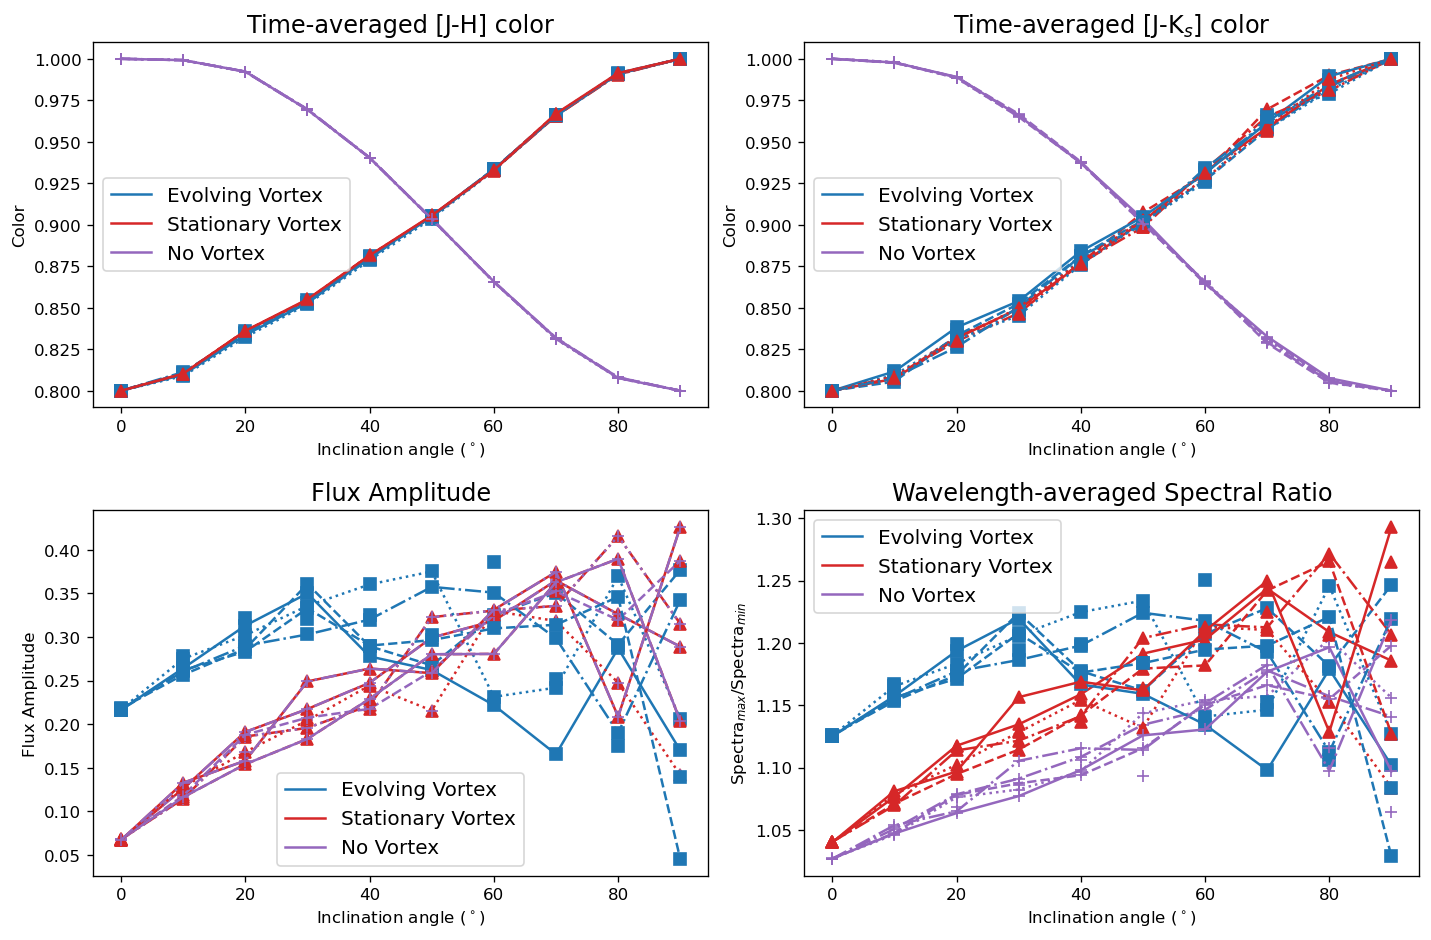

In [19]:
# ==========================================================
## The plot: composite JH-inclination, JK-inclination, 
## variability-inclination, spectra ratio -inclination
# ==========================================================
save = False
# save = True

titles = ['Stationary polar vortex', 'Evolving polar vortex']
fig, axs = plt.subplots(2, 2, figsize=(12, 8), dpi=120)
plt.rcParams.update({'font.size': 12})
lsizes = [1.5, 1.25, 1]

# for counter in range(len(production_keys)):
for counter in range(len(production_keys)):
    for n, typename in enumerate(['JH_color', 'JK_color']):
        for i, model in enumerate(['polarStatic', 'noPolar', 'nothing']):
            line, mark = next(linestyleRandomList), markers[i]
            
            x = amplitudes[model][counter][typename][:,0]
            y = amplitudes[model][counter][typename][:,1]

            # rescaling
            scale, offset = np.linalg.solve(b=(0.8, 1.0), a=((np.min(y), 1), (np.max(y), 1)))

            axs[0,n].plot(x+90, y*scale + offset, ls=line, marker=mark, 
                          c=colorList[model], ms=7)

            if n==0:
                y2 = amplitudes[model][counter]['flux'][:,1]
                y3 = amplitudes[model][counter]['specRatio'][:,1]
                axs[1,0].plot(x+90, y2, ls=line, marker=mark, c=colorList[model], ms=7)
                axs[1,1].plot(x+90, y3, ls=line, marker=mark, c=colorList[model], ms=7)
                
                if counter == 0:
                    axs[1,0].plot([], [], ls='-', c=colorList[model], label=aliasList[model])
                    axs[1,1].plot([], [], ls='-', c=colorList[model], label=aliasList[model])
                    axs[0,0].plot([], [], ls='-', c=colorList[model], label=aliasList[model])
                    axs[0,1].plot([], [], ls='-', c=colorList[model], label=aliasList[model])
                
        axs[1,0].legend(), axs[1,1].legend()
        axs[0,n].legend()
        axs[1,n].set_xlabel(r'Inclination angle ($^\circ$)')
        axs[0,n].set_xlabel(r'Inclination angle ($^\circ$)')
        axs[0,n].set_title(colorAlias[typename])

axs[0,0].set_ylabel('Color')
axs[0,1].set_ylabel('Color')
axs[1,0].set_ylabel('Flux Amplitude')
axs[1,1].set_ylabel(r'Spectra$_{max}$/Spectra$_{min}$')
axs[1,0].set_title('Flux Amplitude')
axs[1,1].set_title('Wavelength-averaged Spectral Ratio')

plt.tight_layout()

if save:
    plotOut = plotPath + '/2x2_JH_JK_inclinationTrend'
    plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

#### 2G) Plot inclination trends as averages trendlines of phase Randomizations

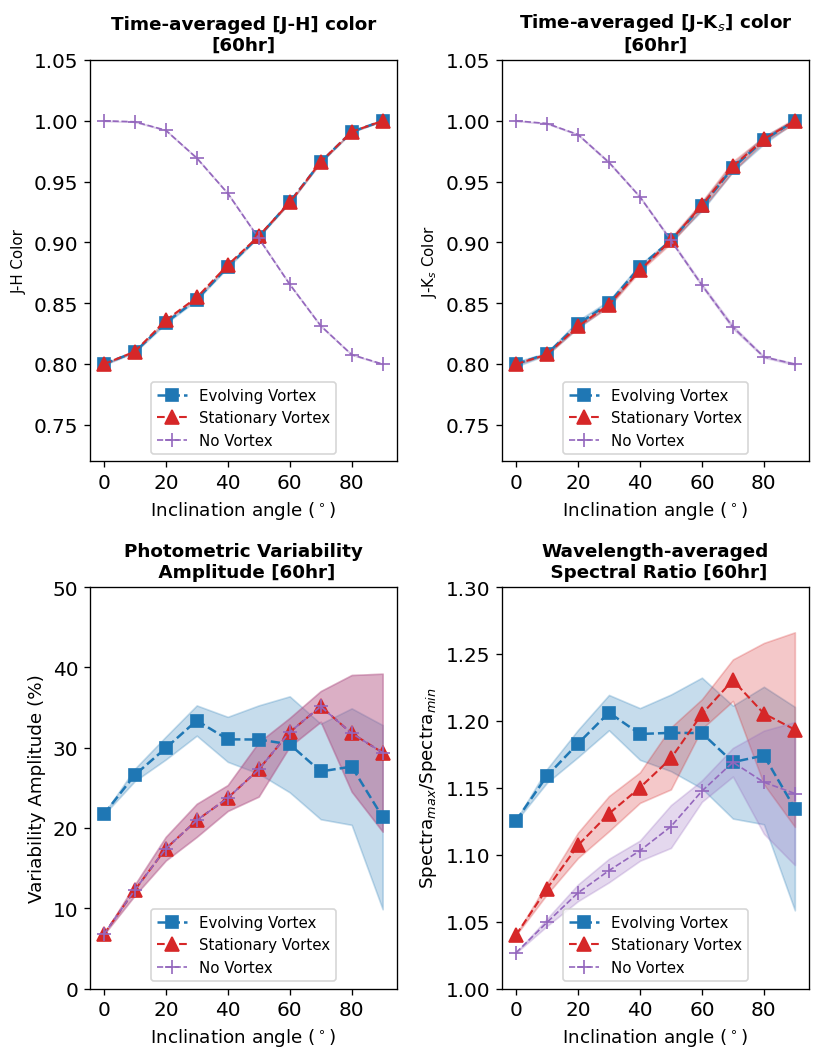

In [20]:
# ==========================================================
## Averaging over all the randPhase config and return mean trendline
# ==========================================================

# save = True
save = False

x_inclination = amplitudes['noPolar'][0]['flux'][:,0]
amplitudes_avg = nested_dict()

for model in ['polarStatic', 'noPolar', 'nothing']:
    for typename in ['JH_color', 'JK_color', 'flux', 'specRatio']:
        yavg, ymin, ymax = [], [], []
        for i, x in enumerate(x_inclination):
            yrange = []
            for counter in range(len(production_keys)):
                value = amplitudes[model][counter][typename][i,1]
                yrange.append(value)
            yavg.append([x, np.mean(yrange)])
            ymax.append([x, np.mean(yrange) + np.std(yrange)])
            ymin.append([x, np.mean(yrange) - np.std(yrange)])
            
            # yavg.append([x, np.mean(yrange)])
            # ymax.append([x, np.partition(yrange,1)[-1]])
            # ymin.append([x, np.partition(yrange,1)[1]])
            
        amplitudes_avg[model][typename]['avg'] = np.array(yavg)
        amplitudes_avg[model][typename]['max'] = np.array(ymax)
        amplitudes_avg[model][typename]['min'] = np.array(ymin)
                
#### Plot 2x2 observables with inclinations
fig, axs = plt.subplots(2, 2, figsize=(7, 9), dpi=120)
plt.rcParams.update({'font.size': 12})
markers = ['s', '^', '+']
lsizes = [1.5, 1.25, 1]
offset_list = [0, 0, 0.]
line = '--'
msizes = [7,8,8]
for i, model in enumerate(['polarStatic', 'noPolar', 'nothing']):
    
    JHcolor_avg = amplitudes_avg[model]['JH_color']['avg'][:,1]
    JHcolor_min = amplitudes_avg[model]['JH_color']['min'][:,1]
    JHcolor_max = amplitudes_avg[model]['JH_color']['max'][:,1]
    
    JKcolor_avg = amplitudes_avg[model]['JK_color']['avg'][:,1]
    JKcolor_min = amplitudes_avg[model]['JK_color']['min'][:,1]
    JKcolor_max = amplitudes_avg[model]['JK_color']['max'][:,1]
    
    flux_avg = amplitudes_avg[model]['flux']['avg'][:,1] * 100
    flux_min = amplitudes_avg[model]['flux']['min'][:,1] * 100
    flux_max = amplitudes_avg[model]['flux']['max'][:,1] * 100
    
    specRatio_avg = amplitudes_avg[model]['specRatio']['avg'][:,1]
    specRatio_min = amplitudes_avg[model]['specRatio']['min'][:,1]
    specRatio_max = amplitudes_avg[model]['specRatio']['max'][:,1]
    
    ### JHcolor + rescaling
    scale, offset = np.linalg.solve(b=(0.8, 1.0), a=((np.min(JHcolor_avg), 1), (np.max(JHcolor_avg), 1)))
    axs[0,0].plot(x_inclination+90, JHcolor_avg*scale + offset, ls=line, 
                  lw=lsizes[i], marker=markers[i], c=colorList[model], ms=msizes[i], label=aliasList[model])
    axs[0,0].fill_between(x_inclination+90, JHcolor_max*scale + offset, JHcolor_min*scale + offset,
                          color=colorList[model], alpha = 0.25)
    
    ### JKcolor + rescaling
    scale, offset = np.linalg.solve(b=(0.8, 1.0), a=((np.min(JKcolor_avg), 1), (np.max(JKcolor_avg), 1)))
    axs[0,1].plot(x_inclination + 90, JKcolor_avg*scale + offset, ls=line, 
                  lw=lsizes[i], marker=markers[i], c=colorList[model], ms=msizes[i], label=aliasList[model])
    axs[0,1].fill_between(x_inclination+90, JKcolor_max*scale + offset, JKcolor_min*scale + offset,
                          color=colorList[model], alpha = 0.25)
    
    ### flux
    axs[1,0].plot(x_inclination+90, flux_avg-offset_list[i], ls=line, lw=lsizes[i], 
                  marker=markers[i], c=colorList[model], ms=msizes[i], label=aliasList[model])                
    axs[1,0].fill_between(x_inclination+90, flux_max, flux_min, color=colorList[model], alpha = 0.25)

    ### spectral ratio
    axs[1,1].plot(x_inclination+90, specRatio_avg, ls=line, lw=lsizes[i], 
                  marker=markers[i], c=colorList[model], ms=msizes[i], label=aliasList[model])               
    axs[1,1].fill_between(x_inclination+90, specRatio_max, specRatio_min, color=colorList[model], alpha = 0.25)
    
#### formatting
fonttitle = 11
fontnormal = 9
fontsuptitle = 12

lims = [([0.72, 1.05], [0.72, 1.05]), 
        ([0,50], [1, 1.3])]
for m in range(2):
    for n in range(2):
        axs[m,n].legend(loc='lower center', fontsize=fontnormal)
        axs[m,n].set_xlabel(r'Inclination angle ($^\circ$)', fontsize=fonttitle)
        axs[m,n].set_ylim(lims[m][n])
        # axs[m,m].set_xticklabels(fontsize=fontnormal)
        
axs[0,0].set_ylabel(r'J-H Color', fontsize=fontnormal)
axs[0,1].set_ylabel(r'J-K$_s$ Color', fontsize=fontnormal)

# fig.suptitle('Long-duration Monitoring: 60hr Data', fontsize=fontsuptitle)
# axs[1,0].legend(loc='upper left', fontsize=fontnormal)
# axs[1,1].legend(loc='upper left', fontsize=fontnormal)

titleAdd = '[60hr]'
axs[0,0].set_title(colorAlias['JH_color']+'\n'+titleAdd, fontsize=fonttitle, weight='bold')
axs[0,1].set_title(colorAlias['JK_color']+'\n'+titleAdd, fontsize=fonttitle, weight='bold')
    
axs[1,0].set_ylabel('Variability Amplitude (%)', fontsize=fonttitle)
axs[1,1].set_ylabel(r'Spectra$_{max}$/Spectra$_{min}$', fontsize=fonttitle)
axs[1,0].set_title('Photometric Variability\n Amplitude '+titleAdd, fontsize=fonttitle, weight='bold')
axs[1,1].set_title('Wavelength-averaged\n Spectral Ratio '+titleAdd, fontsize=fonttitle, weight='bold')

plt.tight_layout()

if save:
    plotOut = plotPath + '/2x2[60hr][phasesRandomized]observables_inclinationTrend'
    plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

## Step 3: Reproduce color-inclination trends in literature

#### 3A) [read, create] Read external datas and plots
- Vos 2017:
    + **Color anomaly**: Median 2MASS J−Ks color subtracted from the J−Ks color of the objects. Median colors for L0–T6 objects were taken from Schmidt et al. (2010). T7 J−Ks color to be −0.04±0.43
- Suarez 2023:
    + Table 1: Silicate index
    + Table 2: Colors

In [21]:
# =========== Vos 2017 Data ===============
# vos17dataPath = "/Users/nguyendat/Documents/GitHub/polar_vortice/PolarVortice/spitzerData/processed/vos_2017_table.csv"
# nameList = ['Spt','3.6Amp','3.6AmpErr','JAmp','JAmpErr','KepAmp',
#             'Period','PeriodErr','vsini','vsiniErr','JKscolor',
#             'Inclination','inclinationErr','JKanomaly','JKanomalyErr']
# vos17 = pd.read_csv(vos17dataPath, names=nameList, delimiter=';', skiprows=1)

vos17dataPath = '/Users/nguyendat/Documents/GitHub/polar_vortice/PolarVortice/spitzerData/processed/vos_JK_color_anomaly_handInput.csv'
nameList = ['No', 'Inclination', 'JKanomaly', 'inclinationErr1', 'inclinationErr2',
            'JKanomalyErr1', 'JKanomalyErr2']
vos17 = pd.read_csv(vos17dataPath, names=nameList, delimiter=';', skiprows=1)
vos17['inclinationErr1'] = vos17['Inclination'] - vos17['inclinationErr1']
vos17['inclinationErr2'] = vos17['inclinationErr2'] - vos17['Inclination']
vos17['JKanomalyErr1'] = vos17['JKanomaly'] - vos17['JKanomalyErr1']
vos17['JKanomalyErr2'] = vos17['JKanomalyErr2'] - vos17['JKanomaly']

# =========== Suarez 2023 Data ===============
suarez23table1Path = "/Users/nguyendat/Documents/GitHub/polar_vortice/PolarVortice/spitzerData/processed/suarez_2023_table1.csv"
suarez23table1Name = ["2MASSName","ShortName"," SpT(opt)",
                      "Reference1","SpT(IR)","Reference2","SilicateIndex",
                      "Si_err","Inc","IncErr","Reference"]
suarez23table1 = pd.read_csv(suarez23table1Path, delimiter=',', names=suarez23table1Name, skiprows=1)
### 
suarez23table2Path = "/Users/nguyendat/Documents/GitHub/polar_vortice/PolarVortice/spitzerData/processed/suarez_2023_table2.csv"
suarez23table2Name = ["ShortName","J","Jerr","H","Herr",
                      "Ks","Kserr","W1","W1err",
                      "W2","W2err","J-Ks","W1-W2"]
suarez23table2 = pd.read_csv(suarez23table2Path, names=suarez23table2Name, delimiter=',', skiprows=1)
###
suarez23 = suarez23table2.merge(suarez23table1, on='ShortName', how='right')
suarez23['J-H'] = suarez23.J - suarez23.H
suarez23.columns

Index(['ShortName', 'J', 'Jerr', 'H', 'Herr', 'Ks', 'Kserr', 'W1', 'W1err',
       'W2', 'W2err', 'J-Ks', 'W1-W2', '2MASSName', ' SpT(opt)', 'Reference1',
       'SpT(IR)', 'Reference2', 'SilicateIndex', 'Si_err', 'Inc', 'IncErr',
       'Reference', 'J-H'],
      dtype='object')

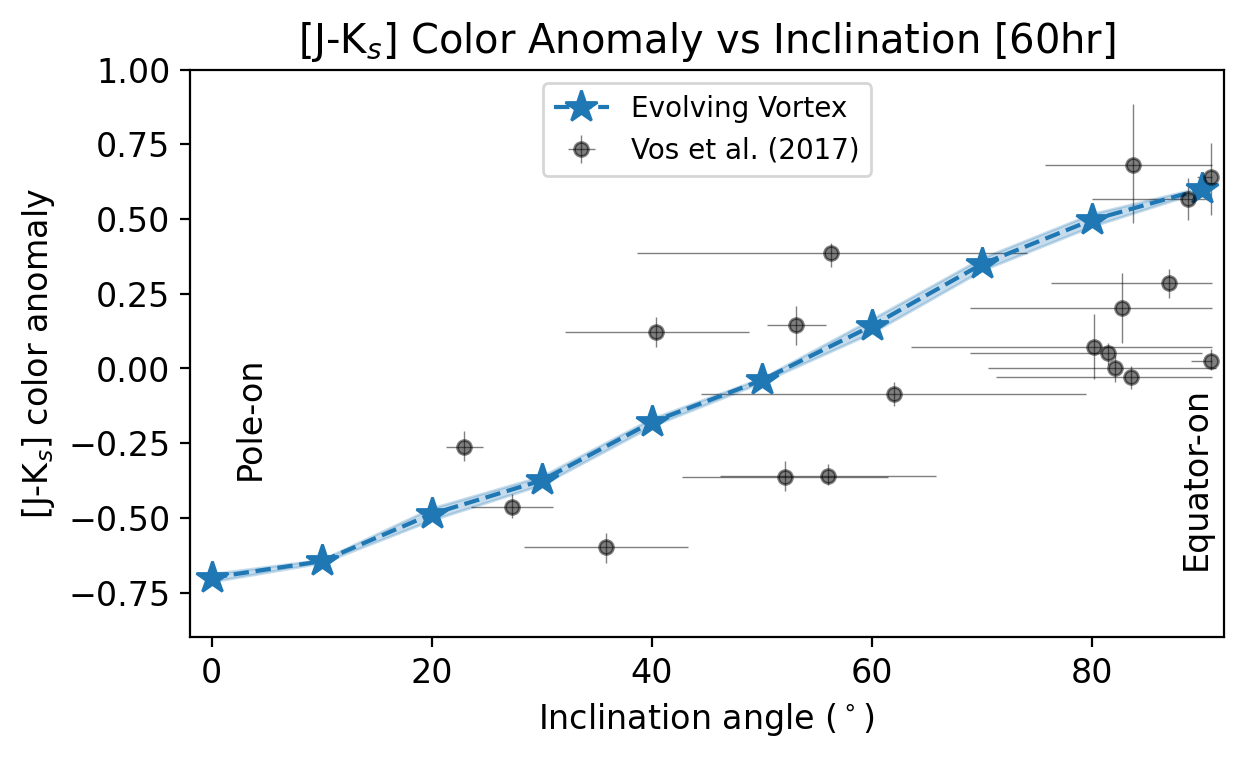

In [31]:
# =========== plot a J-K color anomaly - inclination diagram ===========
plt.close()
plt.rcParams.update({'font.size': 12})

# ==========================================================
## The plot: J-Ks color
# ==========================================================
# titles = ['No polar variation', 'With polar variation', 'Nothing']
# for typename in ['JH_color', 'continuumRatio']:

inclination = vos17['Inclination']
incErr1 = vos17['inclinationErr1'].values
incErr2 = vos17['inclinationErr2'].values
xerrs = np.array([incErr1, incErr2])

JKscolorAnomaly = vos17['JKanomaly']
JKanomalyErr1 = vos17['JKanomalyErr1'].values
JKanomalyErr2 = vos17['JKanomalyErr2'].values
yerrs = np.array([JKanomalyErr1, JKanomalyErr2])

titleAdd = '[60hr]'

# save = True
save = False

# fsed=1
markers = ['*', 's', '^']
fig, ax = plt.subplots(figsize=(6, 3.5), dpi=200)#, gridspec_kw={'width_ratios':[3, 1.5, 3, 1.5]})
plt.tight_layout(w_pad=1, pad=1)

typename='JK_color'

# for i, model in enumerate(['nothing', 'polarStatic', 'noPolar']):
for i, model in enumerate(['polarStatic']):
    x =  amplitudes_avg[model]['JK_color']['avg'][:,0]
    y =  amplitudes_avg[model]['JK_color']['avg'][:,1]
    
    ymin = amplitudes_avg[model]['JK_color']['min'][:,1]
    ymax = amplitudes_avg[model]['JK_color']['max'][:,1]

    # rescaling
    scale, offset = np.linalg.solve(b=(-0.7, 0.6), a=((np.min(y), 1), (np.max(y), 1)))
    ax.plot(x+90, scale*y + offset, ls='--', marker=markers[i], c=colorList[model], ms=12, label=aliasList[model])

    ax.fill_between(x+90, ymax*scale + offset, ymin*scale + offset,
                          color=colorList[model], alpha = 0.25)
    
ax.set_xlabel(r'Inclination angle ($^\circ$)')
ax.text(2, -0.35, 'Pole-on', rotation='vertical')
ax.text(88, -0.65, 'Equator-on', rotation='vertical')
ax.set_title(r'[J-K$_s$] Color Anomaly vs Inclination '+titleAdd)

### Plot Vos2017 color anomaly trend
ax.errorbar(x=inclination, y=JKscolorAnomaly, xerr=xerrs, 
     yerr=yerrs, ls='', marker='o', lw=0.5, ms=5, c='k', alpha=0.5, label = 'Vos et al. (2017)')

ax.legend(loc='upper center', fontsize=10)
ax.set_ylim(-0.9,1.0)
ax.set_xlim(-2, 92)
# ax.text(0, -0.85, 'Pole-on', fontsize=10), ax.text(75, -0.85, 'Equator-on', fontsize=10)
ax.set_ylabel('[J-K$_s$] color anomaly')

if save:
    plotOut = plotPath + '/[60hr][phasesRandomized]_JKColorAnomaly_inclination'
    plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

## Step 5: Understanding the *Variability-Inclination* Trend  

#### 5A) [read]: external variability 3.6 and 4.5um from Spitzer

In [23]:
# save = True
# save = False

vos20Variab36Path = "~/Documents/GitHub/polar_vortice/PolarVortice/spitzerData/variability/vos2020_fig11_variability3.6.csv"
nameList2 = ['Variability', 'Inclination', 'xerr1', 'xerr2', 'yerr1', 'yerr2']

vos20Variab36 = pd.read_csv(vos20Variab36Path, names=nameList2, delimiter=',', skiprows=1)

# ======== edit nan values =========
vos20Variab36['yerr1'][np.isnan(vos20Variab36['yerr1'])] = vos20Variab36['Inclination'][np.isnan(vos20Variab36['yerr1'])]
vos20Variab36['yerr2'][np.isnan(vos20Variab36['yerr2'])] = vos20Variab36['Inclination'][np.isnan(vos20Variab36['yerr2'])]
# vos20Variab36['yerr1'], vos20Variab36['yerr2']
vos20Variab36['xerr1'][np.isnan(vos20Variab36['xerr1'])] = vos20Variab36['Variability'][np.isnan(vos20Variab36['xerr1'])]
vos20Variab36['xerr2'][np.isnan(vos20Variab36['xerr2'])] = vos20Variab36['Variability'][np.isnan(vos20Variab36['xerr2'])]
# vos20Variab36['xerr1'], vos20Variab36['xerr2']
# ===================================

vos20Variab36['inclinationErr1'] = vos20Variab36['Inclination'] - vos20Variab36['yerr1']
vos20Variab36['inclinationErr2'] = vos20Variab36['yerr2'] - vos20Variab36['Inclination']
                                                             
vos20Variab36['variabErr1'] = vos20Variab36['Variability'] - vos20Variab36['xerr1']
vos20Variab36['variabErr2'] = vos20Variab36['xerr2'] - vos20Variab36['Variability']

In [50]:
# def variability_amplitude(n, A_short,A_long, lattitudes, inclination):
#     Asum_short = 0.
#     Asum_long = 0.
    
#     for i in range(n):
#         #print(inclination - lattitudes[i])
#         Asum_short = Asum_short+ A_short[i]*(np.cos(np.radians(inclination-(90.-lattitudes[i]))))**2
#         Asum_long = Asum_long+ A_long[i]*(np.cos(np.radians(inclination-(90.-lattitudes[i]))))**2
#     # print(inclination, Asum_short, Asum_long)
#     return (Asum_short, Asum_long, Asum_short+Asum_long);

# n = 6
# lattitudes = np.array([80.,30.,10.,-10,-30,-80. ])

# A_short1 = np.array([0.01, 0.03, 0.07, 0.07, 0.03, 0.01])
# A_long1  = np.array([0.09, 0.03, 0.01, 0.01, 0.03, 0.09])

# A_short2 = np.array([0.01, 0.06, 0.09, 0.09, 0.06, 0.01])
# A_long2  = np.array([0.01, 0.03, 0.09, 0.09, 0.03, 0.01])
# calc_amp1, calc_amp2 = [], []
# testIncli = np.arange(-10,100,5)

# for inc in testIncli:
#     calc_amp1.append(variability_amplitude(n, A_short, A_long, lattitudes, inc))
#     calc_amp2.append(variability_amplitude(n, A_short2, A_long2, lattitudes, inc))
    
# calc_amp1, calc_amp2 = np.array(calc_amp1), np.array(calc_amp2)    
# analytical1 = calc_amp1[:,2]
# analytical2 = calc_amp2[:,2]

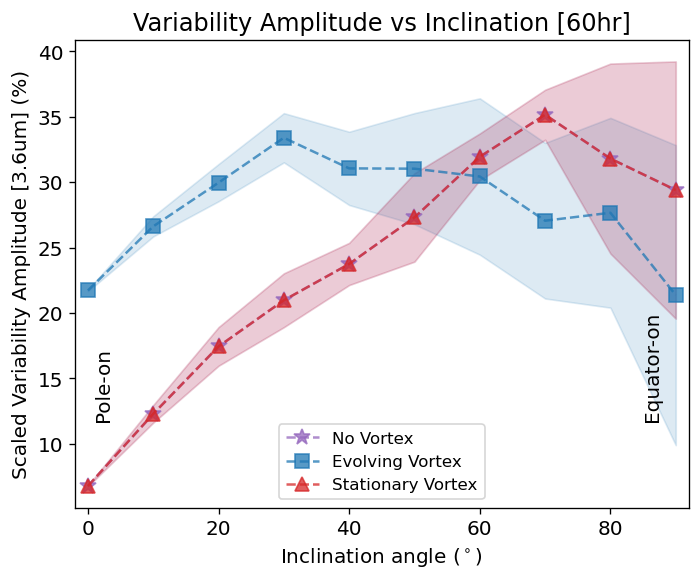

In [24]:
# =========== plot a J-K color - inclination diagram ===========
plt.close()
fig, (ax1) = plt.subplots(dpi=120, figsize=(6,5))
ax1.set_title('Variability Amplitude vs Inclination '+titleAdd)

## ====================================
# save = True
save = False

scalingCalc = False
# scalingCalc = True

# plotAnalytical = True
plotAnalytical = False
## ====================================

msizes = [10, 8, 8]

# rescaling
if scalingCalc: 
    y = amplitudes_avg['noPolar']['flux']['avg'][:,1]
    scale, offset = np.linalg.solve(b=(0, 1.2), a=((np.min(y), 1), (np.max(y), 1)))
else: scale, offset = 100, 0

for i, model in enumerate(['nothing', 'polarStatic', 'noPolar']):
    x = amplitudes_avg[model]['flux']['avg'][:,0]
    y = amplitudes_avg[model]['flux']['avg'][:,1]
    
    flux_min = amplitudes_avg[model]['flux']['min'][:,1]
    flux_max = amplitudes_avg[model]['flux']['max'][:,1] 
    
    ax1.plot(x+90, y*scale, ls='--', marker=markers[i], 
                  c=colorList[model], ms=msizes[i], label=aliasList[model], alpha=0.75)
    ax1.fill_between(x+90, flux_max*scale, flux_min*scale,
                          color=colorList[model], alpha = 0.15)

if plotAnalytical:
    y = amplitudes_avg['noPolar']['flux']['avg'][:,1]
    s2, o2 = np.linalg.solve(b=(10, 30), a=((np.min(y), 1), (np.max(y), 1)))
    s1, o1 = np.linalg.solve(b=(45, 20), a=((np.min(y), 1), (np.max(y), 1)))
    
    ax1.plot(testIncli, s1* analytical1 + o1, '-', c='tab:blue', alpha=0.5, lw=0.75)
    ax1.plot(testIncli, s2* analytical2 + o2, '-', c='xkcd:red', alpha=0.5, lw=0.75)
    
ax1.set_yscale('linear')
# ax1.set_ylim(-0.4, 1.7)
ax1.set_xlim(-5, 91)
ax1.set_xlim(-2, 92)

ax1.set_xlabel(r'Inclination angle ($^\circ$)')
ax1.text(1, 12, 'Pole-on', rotation='vertical')
ax1.text(85, 12, 'Equator-on', rotation='vertical')
ax1.set_ylabel('Scaled Variability Amplitude [3.6um] (%)')
ax1.legend(fontsize=10, loc='lower center')

# # manual regressions
# a1, b1 = np.polyfit([5, 75], [0.35, 1.1], 1)
# a2, b2 = np.polyfit([5, 80], [1.1, 0.2], 1)
# ax1.plot(xtest, a1*xtest + b1, c='tab:red', lw=0.75, alpha=0.75, ls='--')
# ax1.plot(xtest, a2*xtest + b2, c='tab:blue', lw=0.75, alpha=0.75, ls='--')

plt.tight_layout()

if save:
    plotOut = plotPath + '/[60hr][phasesRandomized]variability_inclinationTrend'
    plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')